## Configurations

In [31]:
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

base_path=os.getcwd()+"/../../../"
work_path=base_path+"/Work/GIT_Repository/"
synth_git_path=base_path+"/my_GIT/Synthetic_Airborne_Arctic_ARs/"
budget_script_path=base_path+"/my_GIT/HALO_AC3_AR_Budget_Closure/scripts/"
src_path=synth_git_path+"/src/"
src_plot_path=synth_git_path+"/plotting/"
sys.path.insert(1,synth_git_path)
sys.path.insert(2,src_path)
sys.path.insert(3,src_plot_path)
sys.path.insert(4,work_path)
sys.path.insert(5,budget_script_path)

airborne_data_path=work_path+"hamp_processing_py\\hamp_processing_python\\"#\\Flight_Data\\HALO_AC3\\sea_ice\\"
airborne_importer_path=airborne_data_path#actual_working_path+"/../../"+desired_path_str
import flightcampaign
import data_config
import Performance

performance=Performance.performance()
name="data_config_file"
config_file_exists=False
campaign_name="HALO_AC3"  
flights=["RF05"]
met_variable="IVT"
should_plot_era_map=True
# Check if config-File exists and if not create the relevant first one
if data_config.check_if_config_file_exists(name):
    config_file=data_config.load_config_file(work_path,name)
else:
    data_config.create_new_config_file(file_name=name+".ini")
system_is_windows=True

if system_is_windows:
        if not config_file["Data_Paths"]["system"]=="windows":
            windows_paths={
                "system":"windows",
                "campaign_path":os.getcwd()+"/"    
                    }
            windows_paths["save_path"]=windows_paths["campaign_path"]+"Save_path/"
            data_config.add_entries_to_config_object(name,windows_paths)
        


is_flight_campaign=True
cmpgn_cls=flightcampaign.HALO_AC3(is_flight_campaign=True,
        major_path=config_file["Data_Paths"]["campaign_path"],
        aircraft="HALO",interested_flights=[flights[0]],
        instruments=["radar","radiometer","sonde"])
cmpgn_cls.specify_flights_of_interest(flights)
use_era5_ARs=True

Config-file data_config_file.ini  already exists
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../../..//Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../../..//Work/GIT_Repository//data_config_file.ini.ini  already exists
Overall directory of campaign is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3


In [32]:
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [33]:
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

class StadiaStamen(cimgt.Stamen):
    def _image_url(self, tile):
         x,y,z = tile
         url = f"https://tiles.stadiamaps.com/tiles/stamen_terrain_background/{z}/{x}/{y}.jpg?api_key=0963bb5f-6e8c-4978-9af0-4cd3a2627df9"
        #https://tiles.stadiamaps.com/tiles/stamen_terrain_background/{z}/{x}/{y}.png?api_key={API_KEY}"
         return url

## Plotting functions

In [73]:
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch
import matplotlib.transforms as mtransforms
def add_fancy_patch_around(ax, bb, **kwargs):
    fancy = FancyBboxPatch(bb.p0, bb.width, bb.height,
                           fc=(1, 0.8, 1, 0.5), ec=(1, 0.5, 1, 0.5),
                           **kwargs)
    ax.add_patch(fancy)
    return fancy
def plot_AR_map_with_budget_HALO_ICON_comparison(era5,halo_df,icon_ivt,Dropsondes):
    matplotlib.rcParams.update({"font.size":16})
    i=9 # hour index
    print("Hour of the day:",i)
    #x1, y1 = coordinates["Kiruna"]  
    calc_time=era5.hours[i]
    #70N - 85N 20W - 30E
    big_extent=[-25,25,70,85]#[-40,30,55,90]
    # Background terrain
    stamen_terrain = StadiaStamen('terrain-background')

    coordinates= dict(EDMO=(11.28, 48.08), 
                      Kiruna=(20.336, 67.821),
                      Longyearbyen=(15.46, 78.25),
                      Meiningen=(10.38, 50.56),
                      Lerwick=(-1.18, 60.13),
                      Ittoqqortoormiit=(-21.95, 70.48),
                      Tasiilaq=(-37.63, 65.60))
    coordinates["Ny-Alesund"]=(11.909895,78.923538)
    x1, y1 = coordinates["Kiruna"]   
    #Create a GeoAxes in the tile's projection.
    x=np.linspace(-90,90,41)
    y=np.linspace(55,90,93)
    x_grid,y_grid=np.meshgrid(x,y)
    white_overlay= np.zeros((41,93))
    plt.rcdefaults()
    icon_box_lon=[np.linspace(30,-20, 1000), np.array([-20, -20]),
                    np.linspace(-20, 30, 1000), np.array([30.0, 30.0])]
    icon_box_lat=[np.linspace(70.5, 70.5,1000),np.array([70.5,85.5]),
                  np.linspace(85.5, 85.5, 1000), np.array([85.5, 70.5])]             

    fig = plt.figure(figsize=(18,9))
    ax1=fig.add_subplot(121,projection=ccrs.NorthPolarStereo(central_longitude=0))
    # Terrain    
    ax1.text(-0.05,1.05,"(a)",fontsize=18,transform=ax1.transAxes)
    ax1.add_image(stamen_terrain, 3)
    ax1.set_extent([big_extent[0]+1,big_extent[1]+3,big_extent[2]-5,big_extent[3]+3],
                   crs=ccrs.Geodetic())
    ax1.contourf(x_grid,y_grid,white_overlay.T,cmap="Greys",vmin=0,vmax=1,
                 transform=ccrs.PlateCarree(),alpha=0.4)
    # Sea ice
    ax1.pcolormesh(seaice.lon, seaice.lat,np.array(seaice[:]), 
                transform=ccrs.PlateCarree(), cmap=reversed_map)
    # ICON IVT
    C1=ax1.scatter(np.rad2deg(icon_ivt["lon"]),np.rad2deg(icon_ivt["lat"]),c=icon_ivt["IVT"],s=0.01,cmap='magma_r',
                transform=ccrs.PlateCarree(),vmin=ivt_threshold,vmax=500,alpha=0.7)
    cbaxes = fig.add_axes([0.145, 0.135, 0.2, 0.02]) 
    cbar=plt.colorbar(C1,cax=cbaxes, ticks=[ivt_threshold,(500+ivt_threshold)/2,500], orientation='horizontal',extend="max")# ICON BOX
    cbar.ax.set_xlabel('IVT (kg $\mathrm{m}^{-1}\,\mathrm{s}^{-1}$)',color="k",fontsize=16)
    cbar.ax.tick_params(labelcolor="k",labelsize=16)
    for edge_lon, edge_lat in  \
                        zip(icon_box_lon, icon_box_lat):
        ax1.plot(edge_lon, edge_lat,
             color="grey", lw=4,ls="-", 
             transform=ccrs.PlateCarree(),
                zorder=3)
        ax1.plot(edge_lon, edge_lat,
             color="orange", lw=2,ls="-.", 
             transform=ccrs.PlateCarree(),
                zorder=4)
    icon_legend_patch_name="ICON-2km domain"
    #------------------------------------------------------------------
    # HALO
    # entire flight track
    ax1.plot(halo_df["longitude"],halo_df["latitude"],color="lightgrey",lw=3,ls="--",transform=ccrs.PlateCarree())
    # Sector legs
    inflow_times=["2022-03-15 10:11","2022-03-15 11:08"]
    internal_times=["2022-03-15 11:17","2022-03-15 12:13"]
    outflow_times=["2022-03-15 12:20","2022-03-15 13:14"]

    ax1.text(x1 - 5.5, y1 - 0.5, "Kiruna (KRN)", fontsize=12,
                 transform=ccrs.PlateCarree(),color="red",
                 bbox=dict(facecolor='lightgrey',edgecolor="black"))
    ax1.plot(halo_df["longitude"].loc[inflow_times[0]:inflow_times[-1]],
             halo_df["latitude"].loc[inflow_times[0]:inflow_times[-1]],lw=8,color="lightgrey",
             transform=ccrs.PlateCarree(),zorder=5)
    ax1.plot(halo_df["longitude"].loc[internal_times[0]:internal_times[-1]],
             halo_df["latitude"].loc[internal_times[0]:internal_times[-1]],lw=8,color="lightgrey",
             transform=ccrs.PlateCarree(),zorder=5)
    ax1.plot(halo_df["longitude"].loc[outflow_times[0]:outflow_times[-1]],
             halo_df["latitude"].loc[outflow_times[0]:outflow_times[-1]],lw=8,color="lightgrey",
            transform=ccrs.PlateCarree(),zorder=5)
    ax1.plot(halo_df["longitude"].loc[inflow_times[0]:inflow_times[-1]],
             halo_df["latitude"].loc[inflow_times[0]:inflow_times[-1]],lw=4,color="lightgreen",
             label="cross-section leg",transform=ccrs.PlateCarree(),zorder=5)
    ax1.plot(halo_df["longitude"].loc[internal_times[0]:internal_times[-1]],
             halo_df["latitude"].loc[internal_times[0]:internal_times[-1]],lw=4,color="teal",#"darkgreen",
             label="internal leg",transform=ccrs.PlateCarree(),zorder=5)
    ax1.plot(halo_df["longitude"].loc[outflow_times[0]:outflow_times[-1]],
             halo_df["latitude"].loc[outflow_times[0]:outflow_times[-1]],lw=4,color="lightgreen",
            transform=ccrs.PlateCarree(),zorder=5)

    ax1.scatter(x1,y1,s=100,transform=ccrs.PlateCarree(),color="red",edgecolor="k")
    ax1.coastlines(resolution="50m")
    ax1.add_feature(cartopy.feature.BORDERS)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                                  x_inline=False, y_inline=False)

    # Dropsondes
    ax1.scatter(Dropsondes["Lon"].values,Dropsondes["Lat"].values,
                    marker="v",s=100,color="whitesmoke",edgecolor="dimgrey",
                    transform=ccrs.PlateCarree(),zorder=10)
    ax1.scatter(Dropsondes["Lon"].iloc[relevant_sondes_dict["warm_sector"]["in"]],
                Dropsondes["Lat"].iloc[relevant_sondes_dict["warm_sector"]["in"]],
                marker="v",s=200,color="mintcream",edgecolor="k",
                transform=ccrs.PlateCarree(),zorder=10)
    ax1.scatter(Dropsondes["Lon"].iloc[internal_sondes_dict["warm"]],
                Dropsondes["Lat"].iloc[internal_sondes_dict["warm"]],
               marker="v",s=100,color="whitesmoke",edgecolor="dimgrey",transform=ccrs.PlateCarree(),zorder=10)

    ax1.scatter(Dropsondes["Lon"].iloc[relevant_sondes_dict["warm_sector"]["out"]],
                Dropsondes["Lat"].iloc[relevant_sondes_dict["warm_sector"]["out"]],
               marker="v",s=200,color="mintcream",edgecolor="k",transform=ccrs.PlateCarree(),zorder=10)

    #ax1.scatter(Dropsondes["Lon"].iloc[relevant_sondes_dict["cold_sector"]["in"]],
    #            Dropsondes["Lat"].iloc[relevant_sondes_dict["cold_sector"]["in"]],
    #           marker="v",s=100,color="blue",edgecolor="k",transform=ccrs.PlateCarree())

    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 18}
    gl.ylabel_style = {'size': 18}
    ax1.legend(loc="lower left",fontsize=14,facecolor="whitesmoke",framealpha=0.8,edgecolor="k",title="Flight legs",
              title_fontsize=14,alignment='left')

    markersize=300
    ms=20
    ax2=fig.add_subplot(122)
    ax2.text(-0.15,0.975,"(b)",fontsize=18,transform=ax2.transAxes)
    ax2.text(0.35,0.9,"HALO obs \n\nICON along HALO",fontsize=16,
             horizontalalignment='left',transform=ax2.transAxes)
    #----------------------------------------------------------------------------
    # dIWV/dt
    # HALO
    d_IWV_dt_hamp=pd.Series(data=[-0.72,-0.19,0.66,0.56],index=["S1","S2","S3","S4"]) 
    d_IWV_dt_uncertainty=pd.Series(data=[0.21,0.23872126958677942,0.30,0.1],index=["S1","S2","S3","S4"])
    ax2.errorbar([1.375],[d_IWV_dt_hamp[0]],
                yerr=[d_IWV_dt_uncertainty[0]],
                marker="v",ms=ms,markeredgecolor="k",mfc="teal",elinewidth=2,ecolor="teal",ls="",markeredgewidth=2,zorder=2)
    # ICON
    d_IWV_dt_icon=-0.4273540676372614 
    d_IWV_dt_icon_unc=0.3055211824129308
    ax2.scatter(1.625,-0.42,marker="o",s=markersize,edgecolor="k",linewidth=2,color="teal",zorder=2)
    ax2.plot([1.625,1.625],[d_IWV_dt_icon-d_IWV_dt_icon_unc,d_IWV_dt_icon+d_IWV_dt_icon_unc],
             color="teal",lw=2,ls="-",zorder=2)
    #-----------------------------------------------------------------------------------------------------------------#
    # Mass div
    ax2.errorbar([3.375],-1*halo_sonde_values[flight+"_"+ar_of_day]["mass_div"],
                yerr=halo_sonde_values[flight+"_"+ar_of_day]["mass_div_unc"],
                marker="v",ms=ms,markeredgecolor="k",markeredgewidth=2,mfc="lightgreen",
                elinewidth=2,ecolor="lightgreen",ls="",label="mass CONV",zorder=2)

    ax2.scatter([3.625],-1*icon_sonde_values[flight+"_"+ar_of_day]["mass_div"],
                marker="o",s=markersize,edgecolor="k",facecolor="lightgreen",linewidth=2,linestyle="-",zorder=2)

    ax2.plot([3.625,3.625],[-1*icon_sonde_values[flight+"_"+ar_of_day]["mass_div"]-\
                icon_sonde_values[flight+"_"+ar_of_day]["mass_div_unc"],
                   -1*icon_sonde_values[flight+"_"+ar_of_day]["mass_div"]+\
                icon_sonde_values[flight+"_"+ar_of_day]["mass_div_unc"]],color="lightgreen",ls="-",lw=2,zorder=2)
    #----------------------------------------------------------------------------------------------------------------#
    #Q ADV
    #### HALO
    ax2.errorbar([2.375],-1*halo_sonde_values[flight+"_"+ar_of_day]["q_ADV"],
                yerr=halo_sonde_values[flight+"_"+ar_of_day]["q_ADV_unc"],
                marker="v",ms=ms,markeredgecolor="k",markeredgewidth=2,mfc="lightgreen",elinewidth=2,ecolor="lightgreen",ls="",label="Q ADV",
                zorder=2)
    #### ICON
    ax2.scatter([2.625],-1*icon_sonde_values[flight+"_"+ar_of_day]["q_ADV"],
                #yerr=halo_sonde_values[flight+"_"+ar_of_day]["q_ADV_unc"],
                lw=2,marker="o",s=markersize,edgecolor="k",
                facecolor="lightgreen",linestyle="-",zorder=2)
    ax2.plot([2.625,2.625],[-1*icon_sonde_values[flight+"_"+ar_of_day]["q_ADV"]-\
                icon_sonde_values[flight+"_"+ar_of_day]["q_ADV_unc"],
                -1*icon_sonde_values[flight+"_"+ar_of_day]["q_ADV"]+\
                icon_sonde_values[flight+"_"+ar_of_day]["q_ADV_unc"]],
                color="lightgreen",linestyle="-",lw=2,zorder=2)
    #-----------------------------------------------------------------------------------------------------#
    # Precipitation
    precip_ymin=warm_icon_rain.quantile([0.1,0.9])["Interp_Precip"].iloc[0]
    precip_ymax=warm_icon_rain.quantile([0.1,0.9])["Interp_Precip"].iloc[-1]
    ###ICON
    ax2.plot([4.625,4.625],[warm_icon_rain.quantile([0.1,0.9])["Interp_Precip"].iloc[-0],
                            warm_icon_rain.quantile([0.1,0.9])["Interp_Precip"].iloc[-1]],color="teal",lw=2,ls="-",
            zorder=2)
    ax2.scatter(4.625,warm_icon_rain["Interp_Precip"].mean(),marker="o",s=markersize,color="teal",edgecolor="k",linestyle="-",
               zorder=2,lw=2)
    ###HALO
    ax2.plot([4.375,4.375],[0,merged_precipitation.quantile([0.1,0.9])["rate"].iloc[-1]],color="teal",lw=2,
            zorder=2,)
    ax2.scatter(4.375,merged_precipitation["rate"].mean(),marker="v",s=markersize,color="teal",edgecolor="k",
               zorder=2,lw=2)
    #-----------------------------------------------------------------------------------------------------#
    # Evaporation
    ####ICON
    ICON_Evap_Sectors={}
    ICON_Evap_Sectors["mean"]=[-0.0013212743604341494] # ICON values from internal_evaporation notebook
    ICON_Evap_Sectors["std"]=[0.008429681186788331]
    ax2.plot([5.625,5.625],[ICON_Evap_Sectors["mean"][0]-ICON_Evap_Sectors["std"][0],
                            ICON_Evap_Sectors["mean"][0]+ICON_Evap_Sectors["std"][0]], color="teal",lw=2,ls="-",zorder=2)
    ax2.scatter(5.625,ICON_Evap_Sectors["mean"][0],marker="o",s=markersize,color="teal",
                edgecolor="k",lw=2,linestyle="-",zorder=2)


    ### HALO
    ax2.plot([5.375,5.375],[0,0.005], color="teal",lw=2,ls="-",zorder=2) ### ---> fill value
    ax2.scatter(5.375,0.002,marker="v",s=markersize,color="teal",edgecolor="k",lw=2,zorder=2)
    #-----------------------------------------------------------------------------------------------------------------------------
    # Cosmetics
    ax2.spines['left'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax2.xaxis.set_tick_params(width=2,length=4)
    ax2.yaxis.set_tick_params(width=2,length=4)
    for spines in ["right","top"]:
        ax2.spines[spines].set_visible(False)
    ax2.set_xlim([1,6])
    ax2.set_xticks([1.5,2.5,3.5,4.5,5.5])
    ax2.set_xticklabels(["dIWV/dt","$ADV$","$DIV_{\mathrm{mass}}$","Precip","Evap"],fontsize=16)
    ax2.set_ylabel("Moisture budget \n contribution ($\mathrm{mm}\,\mathrm{h}^{-1}$)",fontsize=16)
    ax2.set_ylim([-1,1.02])
    ax2.set_yticks([-1,-0.5,0,0.5,1])
    ax2.set_yticklabels(["-1","-0.5","0","0.5","1"],fontsize=16)
    ax2.grid(axis='x', color="grey",ls=":",lw=1)
    ax2.axhline(y=0,ls="--",color="darkgrey",lw=3,zorder=0)
    ax2.scatter(1.4,0.975,s=markersize,marker="v",color="grey",edgecolor="k")
    ax2.scatter(1.4,0.825,s=markersize,marker="o",color="grey",edgecolor="k")
    plt.subplots_adjust(wspace=0.25)
    fig_path=os.getcwd()+"/../plots/"
    fig_name="S1_AR_Budget_components_intercomparison_HALO_ICON.png"
    fig.savefig(fig_path+fig_name,dpi=600,bbox_inches="tight")
    print("Figure saved as:", fig_path+fig_name)

In [35]:
import matplotlib
import matplotlib.pyplot as plt
from reanalysis import ERA5
from ICON import ICON_NWP as ICON
set_font=16
matplotlib.rcParams.update({'font.size':set_font})
plt.rcParams.update({'hatch.color': 'k'})  
plt.rcParams.update({'hatch.linewidth':1.5})

campaign_cls=cmpgn_cls
flight=flights[0]
# Define the plot specifications for the given variables

met_var_dict={}
met_var_dict["ERA_name"] = {"IWV":"tcwv","IVT":"IVT",
                           "IVT_u":"IVT_u","IVT_v":"IVT_v"}
met_var_dict["colormap"] = {"IWV":"density","IVT":"ocean_r",
                           "IVT_v":"speed",
                           "IVT_u":"speed"}
met_var_dict["levels"]   = {"IWV":np.linspace(10,25,101),
                           "IVT":np.linspace(50,500,101),
                           "IVT_v":np.linspace(0,500,101),
                           "IVT_u":np.linspace(0,500,101)}
met_var_dict["units"]    = {"IWV":"(kg$\mathrm{m}^{-2}$)",
                           "IVT":"(kg$\mathrm{m}^{-1}\mathrm{s}^{-1}$)",
                           "IVT_v":"(kg$\mathrm{m}^{-1}\mathrm{s}^{-1}$)",
                           "IVT_u":"(kg$\mathrm{m}^{-1}\mathrm{s}^{-1}$)"}

flight_date=campaign_cls.year+"-"+campaign_cls.flight_month[flight]
flight_date=flight_date+"-"+campaign_cls.flight_day[flight]


era5=ERA5(for_flight_campaign=True,campaign=campaign_cls.name,
      research_flights=flight,
      era_path=campaign_cls.campaign_path+"/data/ERA-5/")
plot_path=campaign_cls.campaign_path+"/plots/"+flight+"/"
hydrometeor_lvls_path=campaign_cls.campaign_path+"/data/ERA-5/"

file_name="total_columns_"+campaign_cls.year+"_"+\
                        campaign_cls.flight_month[flight]+"_"+\
                        campaign_cls.flight_day[flight]+".nc"    

ds,era_path=era5.load_era5_data(file_name)

ds["IVT_v"]=ds["p72.162"]
ds["IVT_u"]=ds["p71.162"]
ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)



# Load Flight Track
halo_dict={}
cmpgn_cls.load_AC3_bahamas_ds(flight)
halo_dict=cmpgn_cls.bahamas_ds

if isinstance(halo_dict,pd.DataFrame):
    halo_df=halo_dict.copy() 
elif isinstance(halo_dict,xr.Dataset):
    halo_df=pd.DataFrame(data=np.nan,columns=["alt","Lon","Lat"],
                    index=pd.DatetimeIndex(np.array(halo_dict["TIME"][:])))
    halo_df["Lon"]=halo_dict["IRS_LON"].data
    halo_df["Lat"]=halo_dict["IRS_LAT"].data
    if len(halo_dict.keys())==1:
        halo_df=halo_dict.values()[0]
else:   
        halo_df=pd.concat([halo_dict["inflow"],halo_dict["internal"],
                           halo_dict["outflow"]])
        halo_df.index=pd.DatetimeIndex(halo_df.index)

halo_df["Hour"]=halo_df.index.hour
halo_df=halo_df.rename(columns={"Lon":"longitude",
                        "Lat":"latitude"})
date=str(halo_df.index.date[0])
flight_date_int=''.join(date.split("-"))

## Sea-ice

In [36]:
def extract_and_add_date(file):
    date=date=file[-16:-8]
    grid_time = pd.to_datetime(date)
    return ds.assign(time=grid_time)

def add_time_dim(xda):
    from datetime import datetime
    xda = xda.expand_dims(time = [datetime.now()])
    return xda    

use_amsr2_sea_ice=True
draw_multibox=True
amsr2_sea_ice_path=airborne_importer_path+"Flight_Data\\HALO_AC3\\sea_ice\\"
import glob
sea_ice_file_list=glob.glob(amsr2_sea_ice_path+"*"+flight_date_int+"*.nc")
sea_ice_ds=xr.open_dataset(sea_ice_file_list[0])
seaice=sea_ice_ds["seaice"]

## ICON

In [37]:
# load hydrometeor ICON files for precipitation
central_hour="12"
ar_of_day="AR_entire_1"
# IWV, Precip and so on
# Vertical profiles
icon_major_path       = work_path+campaign_name+"/data/ICON_LEM_2KM/"
hydrometeor_icon_path =work_path+campaign_name+"/data/ICON_LEM_2KM/"
flight_list=[flight]
icon_resolution=2000 # units m
upsample_time="10min"
icon_var_list=ICON.lookup_ICON_AR_period_data(campaign_name,flight_list,ar_of_day,
                                         icon_resolution,
                                         hydrometeor_icon_path,
                                         synthetic=False)
interp_icon_hmp_file=flight[0]+"_"+ar_of_day+"_"+"interpolated_HMP.csv"

import gridonhalo as Grid_on_HALO

ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
                    cmpgn_cls,icon_var_list,halo_df,flight_list,date,
                    interpolated_hmp_file=interp_icon_hmp_file,
                    interpolated_hmc_file=None,ar_of_day=ar_of_day,
                    upsample_time=upsample_time,
                    synthetic_icon=False,
                    synthetic_flight=False)

hydrometeor_icon_path=hydrometeor_icon_path+flight+"/"
ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)

icon_var_dict={}
# read the data
for var in ["Pressure","Specific_humidity","U_wind","V_wind","Z_height"]:
    print(var)
    hour="12"
    icon_q_file=var+"_"+ICON_on_HALO.flight+"_"+\
                            ICON_on_HALO.ar_of_day+"_"+hour+"UTC.nc"
    icon_ds=xr.open_dataset(ICON_on_HALO.hydrometeor_icon_path+\
                            icon_q_file)
    icon_ds=icon_ds.astype(np.float32)
    if not var=="Z_height":
        icon_ds=icon_ds.isel({"time":0})
    icon_var_dict[var]=icon_ds.copy()
    del icon_ds

Pressure
Specific_humidity
U_wind
V_wind
Z_height


In [60]:
# Calc IVT
g= 9.81
ivt_threshold=250
q_loc= pd.DataFrame(data=np.array(icon_var_dict["Specific_humidity"]["qv"].values[:].T),
                    index=np.array(icon_var_dict["Specific_humidity"].ncells.values[:]),
                    columns=np.array(icon_var_dict["Specific_humidity"].height.values[:]))
u_loc= pd.DataFrame(data=np.array(icon_var_dict["U_wind"]["u"].values[:].T),
                    index=np.array(icon_var_dict["U_wind"]["u"].ncells.values[:]),
                    columns=np.array(icon_var_dict["U_wind"]["u"].height.values[:]))
v_loc= pd.DataFrame(data=np.array(icon_var_dict["V_wind"]["v"].values[:].T),
                    index=np.array(icon_var_dict["V_wind"]["v"].ncells.values[:]),
                    columns=np.array(icon_var_dict["V_wind"]["v"].height.values[:]))

qu=q_loc*u_loc
qv=q_loc*v_loc
pres=pd.DataFrame(data=np.array(icon_var_dict["Pressure"]["pres"].values[:].T),
                        index=np.array(icon_var_dict["Pressure"]["pres"].ncells.values[:]),
                        columns=np.array(icon_var_dict["Pressure"]["pres"].height.values[:]))

icon_ivt=pd.DataFrame(data=np.nan,
                      index=u_loc.index,
                      columns=["IVT","IWV_calc","IVT_u","IVT_v","lat","lon"])
range_index=u_loc.shape[0]#1000100000u_loc.shape[0]
for ts in range(range_index):
    icon_ivt["IWV_calc"].iloc[ts]= 1/g*np.trapz(q_loc.iloc[ts,:].dropna(),x=pres.iloc[ts,:].dropna())
    icon_ivt["IVT_u"].iloc[ts] = 1/g*np.trapz(qu.iloc[ts,:].dropna(),x=pres.iloc[ts,:].dropna())
    
    icon_ivt["IVT_v"].iloc[ts] = 1/g*np.trapz(qv.iloc[ts,:].dropna(),x=pres.iloc[ts,:].dropna())
    performance.updt(range_index, ts)

icon_ivt["lon"]=icon_var_dict["U_wind"].clon.values
icon_ivt["lat"]=icon_var_dict["U_wind"].clat.values

icon_ivt["IVT"]   = np.sqrt(icon_ivt["IVT_u"]**2+icon_ivt["IVT_v"]**2)
icon_ivt["IWV_calc"].max()



[####################] 100% 

16.222777449270513

## Dropsondes

In [61]:
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#        
"""
###############################################################################
    Main Script for running interpolation of griddata on flight path
###############################################################################
"""    
with HiddenPrints():
    halo_era5,halo_ar_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight_list,config_file_path=work_path,ar_of_day=ar_of_day)

In [62]:
# Get relevant sondes
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)
sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))
relevant_sondes_dict={}
internal_sondes_dict={}

relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
relevant_cold_sector_sondes=[4,5,6]
relevant_warm_internal_sondes=[7,13]
relevant_sondes_dict["warm_sector"]        = {}
relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
relevant_sondes_dict["cold_sector"]        = {}
relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
#relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
synthetic_sonde_times_series=pd.Series(data=["7synth","8synth","9synth"],
                         index=pd.DatetimeIndex(["2022-03-15 12:55","2022-03-15 13:05","2022-03-15 13:15"]))
relevant_sondes_dict["cold_sector"]["out"] = synthetic_sonde_times_series
internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
internal_sondes_dict["cold"]               = ["2022-03-15 11:30:00","2022-03-15 13:35"]   

## Plotting

In [63]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.image import imread
    
import seaborn as sns

matplotlib.rcParams.update({"font.size":24})
# getting the original colormap using cm.get_cmap() function
orig_map = plt.cm.get_cmap('Blues')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed() 
# normally the actual bahamas file is used from HALO-(AC)3. However,
# this is not feasible now for testingb

#### Budget contributions

In [64]:
halo_sonde_values={}
halo_sonde_values["RF05_AR_entire_1"]={'mass_div': 0.320,
  'mass_div_min' : 0.056,
  'mass_div_max' : 0.323,
  'mass_div_unc' :0.05606615583661565,
  'q_ADV': 0.162,
  'q_ADV_min': -0.42,
  'q_ADV_max': 0.74,
  'q_ADV_unc':0.139}

icon_sonde_values={}
icon_sonde_values["RF05_AR_entire_1"]={'mass_div': 0.36,
  'mass_div_min' : np.nan,
  'mass_div_max' : np.nan,
  'mass_div_unc' : 0.05,   ##---> preliminary
  'q_ADV': 0.09,
  'q_ADV_min': np.nan,
  'q_ADV_max': np.nan,  ## ---> preliminary
  'q_ADV_unc':0.15}

In [65]:
sector="S1"
rate_path =cmpgn_cls.campaign_path+"/data/precip_rates/"
rate_fname="warm"+"_precip_"+flight+"_"+ar_of_day+".csv"
halo_precip_rates=pd.read_csv(rate_path+rate_fname,index_col=0)
halo_precip_rates["Sector"]=sector
#halo_precip_rates
interp_icon_hmp_file=flight+"_"+ar_of_day+"_"+"interpolated_HMP.csv"
interp_icon_ivt_file=flight+"_"+ar_of_day+"_"+"ICON_Interpolated_IVT.csv"
halo_icon_ivts=pd.read_csv(hydrometeor_icon_path+interp_icon_ivt_file,index_col=0)
halo_icon_ivts["Sector"]=sector
halo_icon_ivts
halo_icon_hmps=pd.read_csv(hydrometeor_icon_path+interp_icon_hmp_file,index_col=0)
warm_icon_rain=halo_icon_hmps.loc[halo_precip_rates.index]
warm_icon_rain.quantile([0.1,0.9])["Interp_Precip"].iloc[-1]
#ICON_on_HALO.load_interpolated_hmp()
#halo_icon_hmps["Sector"]=sector
warm_icon_rain["Interp_Precip"].mean()

0.05900529632816146

In [66]:
halo_precip_rates.index=pd.DatetimeIndex(halo_precip_rates.index)
merged_precipitation=halo_precip_rates.resample("10s").mean()
merged_precipitation["min_rain"]=merged_precipitation[["r_norris","r_palmer","r_chandra"]].min(axis=1)
merged_precipitation["max_rain"]=merged_precipitation[["r_norris","r_palmer","r_chandra"]].max(axis=1)
merged_precipitation["min_snow"]=merged_precipitation[["s_schoger","s_matrosov","s_heymsfield"]].min(axis=1)
merged_precipitation["max_snow"]=merged_precipitation[["s_schoger","s_matrosov","s_heymsfield"]].max(axis=1)
merged_precipitation["min_rate"]=merged_precipitation["min_rain"]+merged_precipitation["min_snow"]
merged_precipitation["max_rate"]=merged_precipitation["max_rain"]+merged_precipitation["max_snow"]
merged_precipitation.quantile([0.1,0.9])

,r_norris,r_palmer,r_chandra,s_schoger,s_matrosov,s_heymsfield,mean_snow,mean_rain,surface,rate,lat,lon,min_rain,max_rain,min_snow,max_snow,min_rate,max_rate
0.1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,71.413034,-4.405588,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
0.9,0.02062,0.039303,0.116614,0.001799,0.002429,0.028081,0.010756,0.059492,0.0,0.061653,76.222605,8.131647,0.02062,0.116614,0.001799,0.028081,0.021079,0.124066


In [67]:
icon_ivt["IVT"][icon_ivt["IVT"]<ivt_threshold]=np.nan

Hour of the day: 9
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/S1_AR_Budget_components_intercomparison_HALO_ICON.png


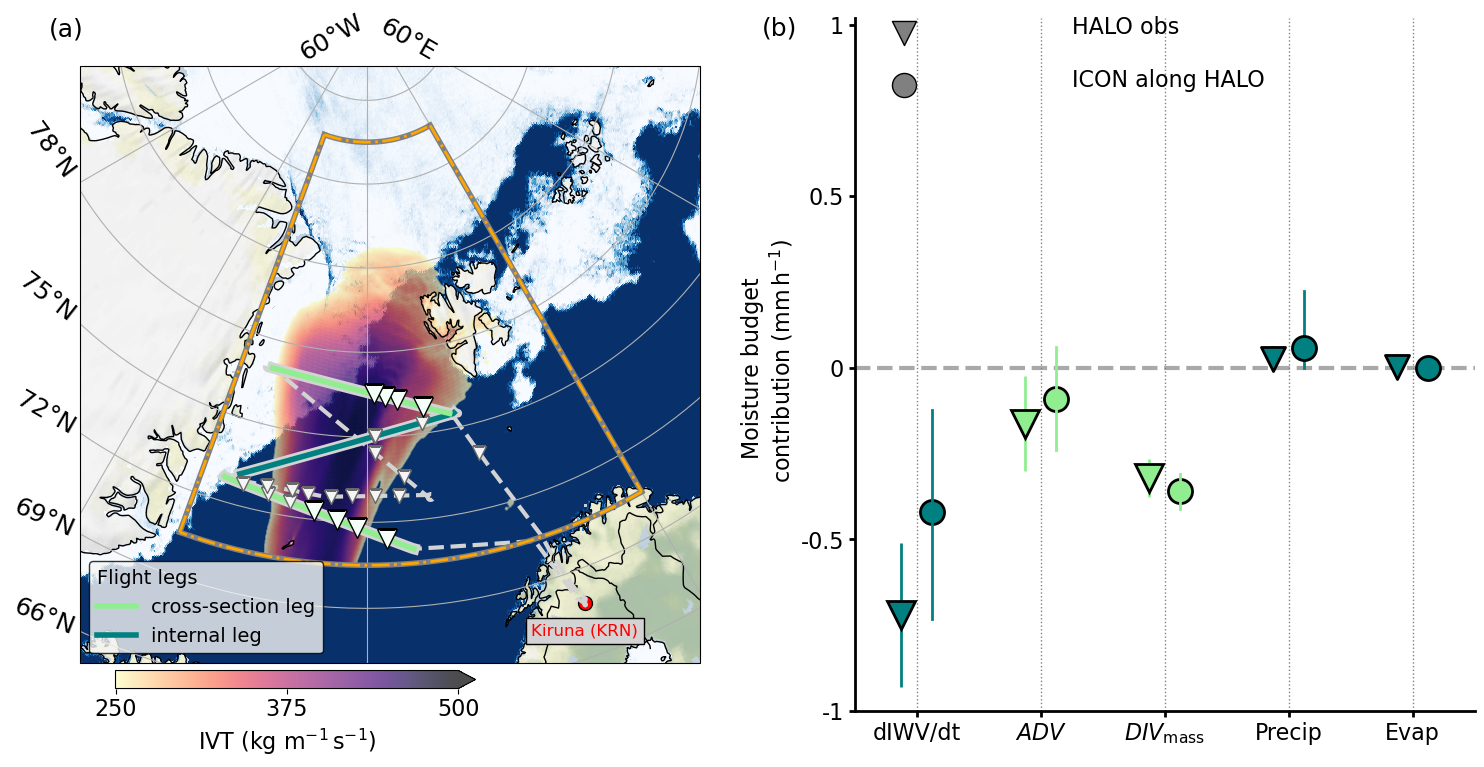

In [74]:
plot_AR_map_with_budget_HALO_ICON_comparison(era5,halo_df,icon_ivt,Dropsondes)

Figure 9: Realisation of airborne derivation of moisture budget components of a specific section in the atmospheric river that was sampled during RF05 (grey dashed lines). For the ICON domain (orange dashed region), simulated IVT values above 250 kg m-1 s-1 are specified in the colourmap. From the flight, two different types of legs allow to derive the moisture budget components (green colour-coded in Fig. a). The two cross-section legs (lightgreen in a) characterise the in- and outgoing IVT for the encompassed flight corridor and AR section. IVT values from the dropsondes (indicated as triangles) enable the derivation of the IVT divergence that is given by the sum of moisture advection (ADV) and mass divergence (DIV_mass) in b). Along the internal leg inside the section (teal-colour flight section), precipitation rate (Precip) is derived from the radar, as well as evaporation and water vapour load, i.e its local tendency from the dropsondes and HAMP respectively. For the eastern half of the AR, b) compares the moisture budget components derived from HALO (triangles) to those from ICON along the HALO track (circles) regarding their contribution to the moisture budget in mm/h. Vertical lines indicate the error bars for each component.
Sea ice cover in a) is given by the AMSR-2 sea ice product (Spreen, 2008).

### Plot AR synoptical conditions RF05

In [17]:
sys.path.insert(6,os.getcwd()+"/../plotting/")
import plot_AR_synoptics

Config-file data_config_file.ini  already exists
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../../..//Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../../..//Work/GIT_Repository//data_config_file.ini.ini  already exists
Overall directory of campaign is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3
Start calculating the different temperatures
Replicate p-levels to ndarray
Calculate Potential Temperature
Calculate Dewpoint
Calculate Equivalent Potential Temperature -- takes a while
Theta_e calculated
ERA dataset now contains new temperature parameters: theta_e, theta
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Fig01_AR_RF05_synoptic_conditions_11_UTC.png


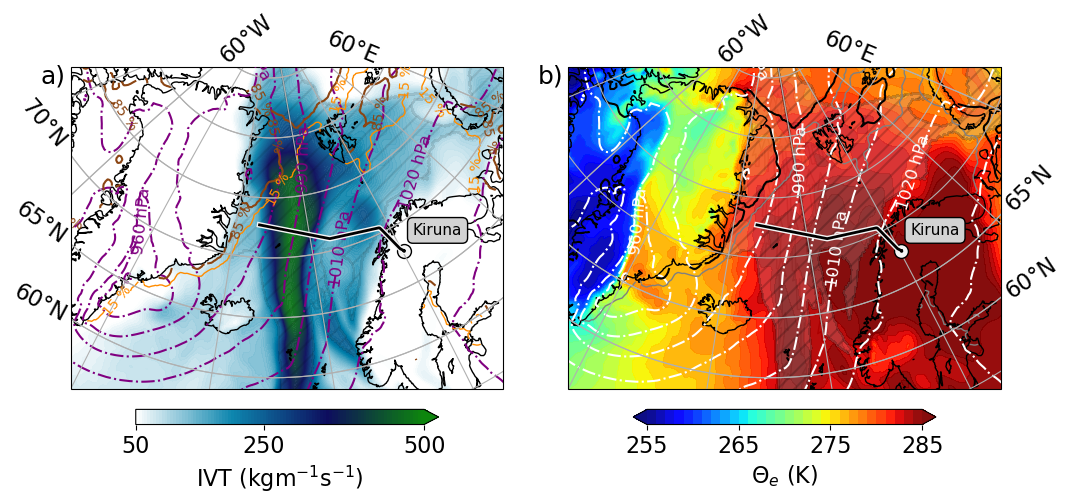

In [18]:
plot_AR_synoptics.main()

### Plot AR IVT tendency RF05/RF06

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\/Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\/Work/GIT_Repository//data_config_file.ini.ini  already exists
Overall directory of campaign is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3
Typhon module cannot be imported
Flight date 20220315
Calculate additional meteorological parameters
[4.499882221221924 nan 4.484301567077637 ... nan nan nan] degree_Celsius [90.09058380126953 nan 90.13389587402344 ... nan nan nan] percent [998.906982421875 nan 997.9724731445312 ... nan nan nan] hectopascal
Flight date 20220316
Calculate additional meteorological parameters
[6.077249050140381 nan nan ... nan nan nan] degree_Celsius [81.2892837524414 nan nan ... nan nan nan] percent [1012.5350341796875 nan nan ... nan nan nan] hectopascal
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_

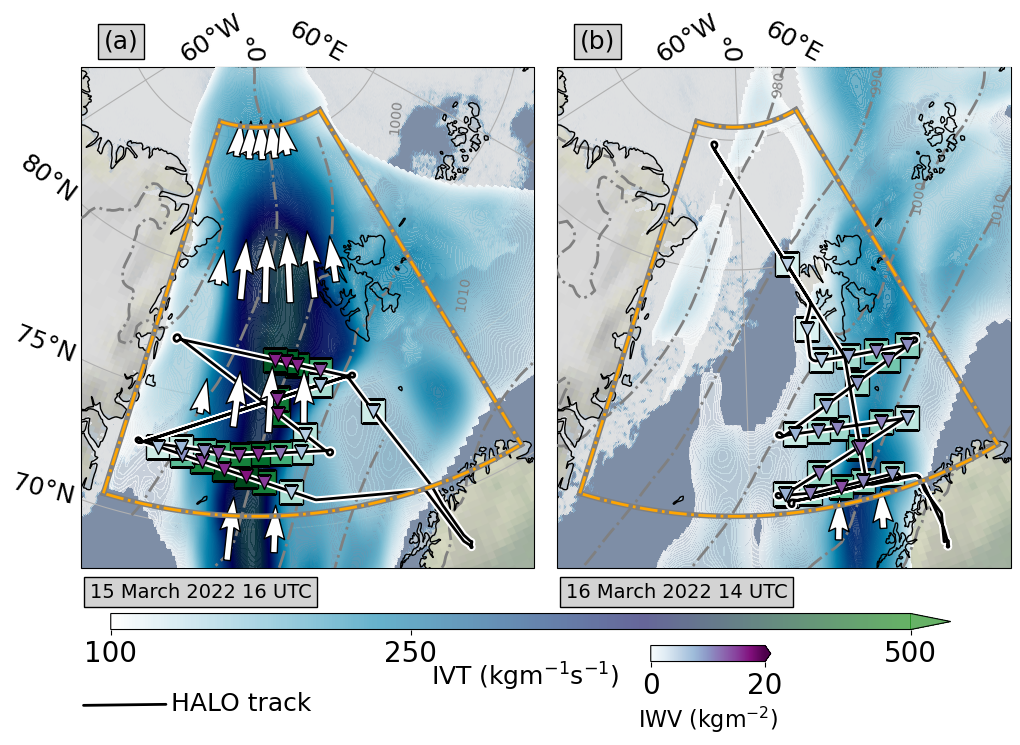

In [20]:
import plot_AR_IVT_tendency
plot_AR_IVT_tendency.main()